In [18]:
import pandas as pd

df = pd.read_csv("../data/all_cleaned_data.csv")
df.head()


,text,emotion
0,"You know, I've been dealing with this whole th...",anger
1,Waking up to prepare for the NSS blood donatio...,neutral
2,Handling the sponsorship for our tech fest as ...,fear
3,Today in the drama club rehearsal as the direc...,joy
4,As the cultural secretary planning the Diwali ...,anger


In [19]:
# Remove exact duplicate rows (same text & emotion)
df = df.drop_duplicates(subset=["text", "emotion"])

# Remove duplicates based only on text, keep first occurrence
df = df.drop_duplicates(subset=["text"])
print("After removing duplicates:", df.shape)


After removing duplicates: (2988, 2)


In [20]:
# Remove rows where text is less than 3 words (after stripping)
def word_count(text):
    return len(str(text).strip().split())

df = df[df["text"].apply(word_count) >= 3]
print("After removing short entries:", df.shape)


After removing short entries: (2978, 2)


In [21]:
df.to_csv("../data/final_cleaned_data.csv", index=False)
print("Final cleaned dataset saved as final_cleaned_data.csv")


Final cleaned dataset saved as final_cleaned_data.csv


In [22]:
print(df["emotion"].value_counts())


emotion
joy        808
sadness    656
fear       464
anger      460
neutral    314
disgust    276
Name: count, dtype: int64


PART 2

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/final_cleaned_data.csv")


In [24]:
print(df.info())
print(df["emotion"].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2978 entries, 0 to 2977
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     2978 non-null   object
 1   emotion  2978 non-null   object
dtypes: object(2)
memory usage: 46.7+ KB
None
emotion
joy        808
sadness    656
fear       464
anger      460
neutral    314
disgust    276
Name: count, dtype: int64


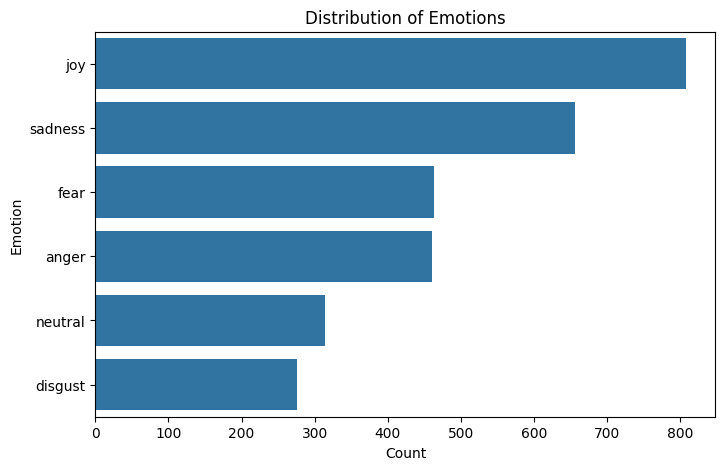

In [25]:
plt.figure(figsize=(8,5))
sns.countplot(y="emotion", data=df, order=df["emotion"].value_counts().index)
plt.title("Distribution of Emotions")
plt.xlabel("Count")
plt.ylabel("Emotion")
plt.show()


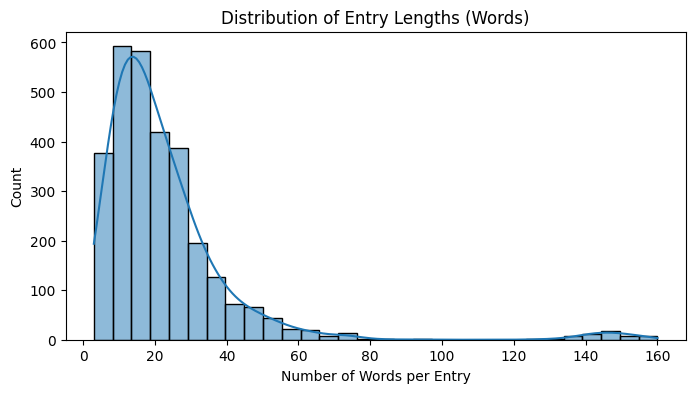

In [26]:
df['text_len'] = df['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,4))
sns.histplot(df['text_len'], bins=30, kde=True)
plt.title("Distribution of Entry Lengths (Words)")
plt.xlabel("Number of Words per Entry")
plt.show()


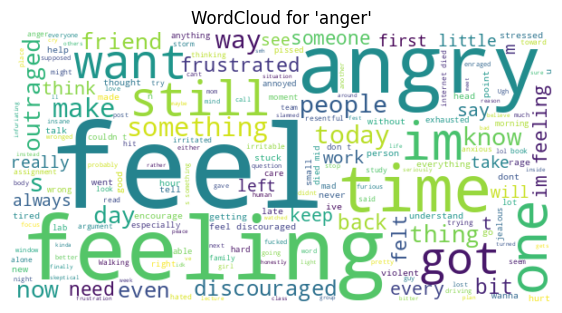

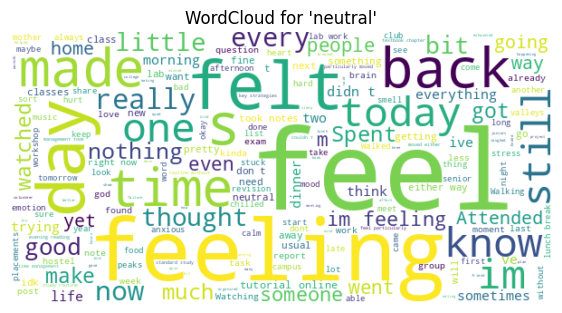

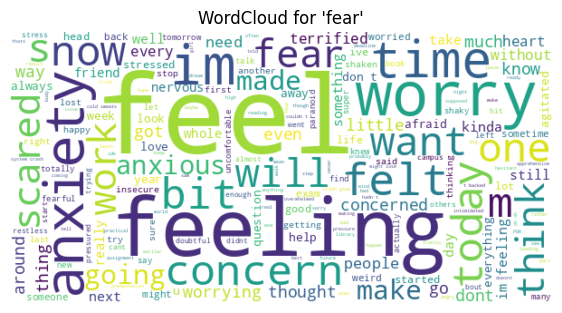

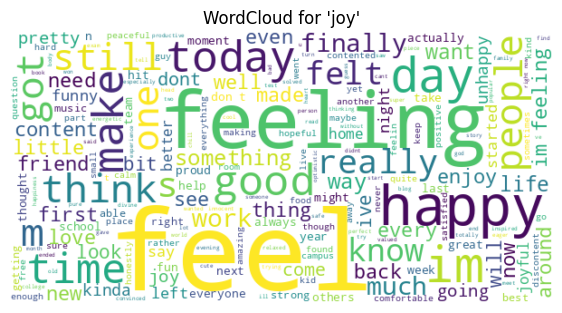

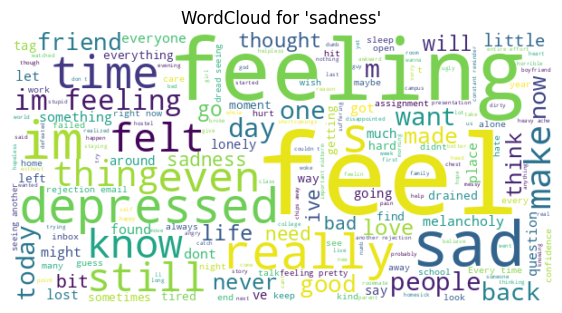

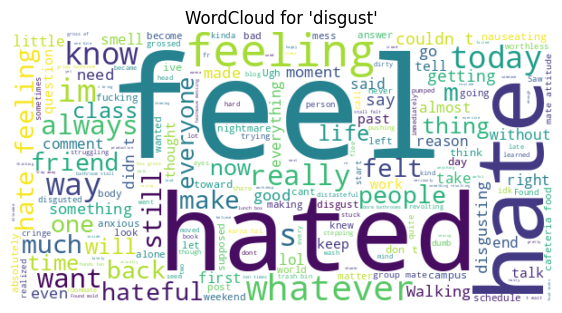

In [27]:
from wordcloud import WordCloud, STOPWORDS

for emo in df['emotion'].unique():
    texts = " ".join(df[df['emotion']==emo]['text'].astype(str))
    wc = WordCloud(width=600, height=300, background_color='white', stopwords=STOPWORDS).generate(texts)
    plt.figure(figsize=(7,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"WordCloud for '{emo}'")
    plt.axis('off')
    plt.show()


In [28]:
# Print a few random entries with emojis or "typical student slang"
import random
emoji_entries = df[df['text'].str.contains(r'[\U0001F600-\U0001F64F]', na=False)]  # emoji unicode range
print("Sample entries with emojis:", emoji_entries['text'].sample(min(5, len(emoji_entries)), random_state=42).tolist())

slang_keywords = ['bro', 'yaar', 'fr', 'idk', 'ikr', 'lol', 'gonna', 'imma', 'vibe', 'ngl', 'lit', 'dope', 'savage', 'lol']
for slang in slang_keywords:
    slang_entries = df[df['text'].str.contains(slang, case=False, na=False)]
    if not slang_entries.empty:
        print(f"\nSample '{slang}' entries:", slang_entries['text'].sample(min(2, len(slang_entries)), random_state=42).tolist())


Sample entries with emojis: ['Feeling pretty ashamed of my actions. Just awful. 😔', 'Fell for my best friend of 6 years. It hit me out of nowhere—now every late-night call feels loaded, and I’m scared to ruin things 😬', 'Roommate left the bathroom filthy again. it’s like living with toddlers, grow up pls 🤢🙄', 'The heatwave messing up schedules was supposed to be routine, but today it became the talk of the campus. At first, I was pumped, pacing back and forth in the corridor, then something clicked—maybe a bit of skeptical mixed in—and I decided to just go with the flow. Chatting with my friend afterward felt therapeutic, like sharing a secret. Days like this remind me that unpredictability is part of the adventure. lol 😍', 'I wanna travel😭🤌']

Sample 'bro' entries: ['i feel that im broke because if i use my credit card then i really dont have cash at all', 'i look at myself in the mirror and see the bronzer i feel like i kind of look fake i dont look like snookie dont worry']

Sample 

PART 3 TRAIN TEST SPLIT

In [29]:
from sklearn.model_selection import train_test_split

train, temp = train_test_split(df, test_size=0.2, stratify=df['emotion'], random_state=42)
val, test = train_test_split(temp, test_size=0.5, stratify=temp['emotion'], random_state=42)

print("Train shape:", train.shape)
print("Val shape:", val.shape)
print("Test shape:", test.shape)

# Save splits for later use
train.to_csv("../data/train.csv", index=False)
val.to_csv("../data/val.csv", index=False)
test.to_csv("../data/test.csv", index=False)


Train shape: (2382, 3)
Val shape: (298, 3)
Test shape: (298, 3)


PART 4 PREPROCESSING FOR FINE TUNING

In [30]:
def clean_text(text):
    text = str(text).lower()
    text = " ".join(text.split())  # removes extra spaces/tabs/newlines
    return text

for df_ in [train, val, test]:
    df_['text'] = df_['text'].apply(clean_text)


In [31]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['label'] = le.fit_transform(train['emotion'])
val['label'] = le.transform(val['emotion'])
test['label'] = le.transform(test['emotion'])

# Save the mapping for inference use later!
import json
with open('../data/label2emotion.json', 'w') as f:
    json.dump({i: l for i, l in enumerate(le.classes_)}, f)


In [32]:
train.to_csv("../data/train_clean.csv", index=False)
val.to_csv("../data/val_clean.csv", index=False)
test.to_csv("../data/test_clean.csv", index=False)


In [33]:
from datasets import load_dataset, DatasetDict

data_files = {
    'train': '../data/train_clean.csv',
    'validation': '../data/val_clean.csv',
    'test': '../data/test_clean.csv'
}

dataset = load_dataset('csv', data_files=data_files)


Generating train split: 2382 examples [00:00, 52022.58 examples/s]
Generating validation split: 298 examples [00:00, 16464.50 examples/s]
Generating test split: 298 examples [00:00, 42481.90 examples/s]


In [36]:
# run_tuning.py
import os
import numpy as np
import pandas as pd
import torch
import evaluate
from datasets import load_dataset # Corrected import from your notebook
from sklearn.preprocessing import LabelEncoder
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

# --- CONFIGURATION SECTION ---

# 1. Define the models you want to compare in the bake-off
MODELS_TO_TEST = [
    "distilbert-base-uncased",
    "vinai/bertweet-base"
]

# 2. Define the hyperparameter search space for the winning model
HYPERPARAMETER_SEARCH_SPACE = [
    {"learning_rate": 2e-5, "num_train_epochs": 5, "per_device_train_batch_size": 16},
    {"learning_rate": 3e-5, "num_train_epochs": 8, "per_device_train_batch_size": 16},
    {"learning_rate": 5e-5, "num_train_epochs": 8, "per_device_train_batch_size": 16},
    {"learning_rate": 3e-5, "num_train_epochs": 8, "per_device_train_batch_size": 32}, # Try if GPU has enough memory
]

# 3. Define data files
# Assuming your script is in the same folder as the notebook, and data is in a subfolder
DATA_FILES = {
    'train': '../data/train_clean.csv',
    'validation': '../data/val_clean.csv',
    'test': '../data/test_clean.csv'
}

# --- DATA LOADING AND PREPARATION ---

print("Loading and preparing data...")
dataset = load_dataset('csv', data_files=DATA_FILES)

# --- ADD THIS SECTION: LABEL ENCODING ---
# This code is moved from your notebook to make the script self-contained
print("Creating label mappings...")
le = LabelEncoder()
le.fit(dataset['train']['emotion']) # Fit on training data to learn all possible labels

# Create label mappings that all functions in this script can access
id2label = {i: str(l) for i, l in enumerate(le.classes_)} # Ensure labels are strings
label2id = {l: i for i, l in enumerate(le.classes_)}

# Transform the string labels in the dataset to integer labels
def transform_labels(batch):
    batch['label'] = le.transform(batch['emotion'])
    return batch

dataset = dataset.map(transform_labels, batched=True)
# ----------------------------------------

# This helper function will be used by our main training function
metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return metric.compute(predictions=preds, references=labels, average="weighted")

# --- CORE TRAINING FUNCTION ---

def train_and_evaluate(model_checkpoint, training_args_dict, run_name):
    """
    Trains and evaluates a model for a given set of parameters.
    Returns the final test results.
    """
    print(f"\n{'='*50}")
    print(f"STARTING RUN: {run_name}")
    print(f"MODEL: {model_checkpoint}")
    print(f"PARAMETERS: {training_args_dict}")
    print(f"{'='*50}\n")
    
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    def tokenize_fn(batch):
        return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)
    
    tokenized_dataset = dataset.map(tokenize_fn, batched=True, remove_columns=['text', 'emotion'])
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_checkpoint,
        num_labels=len(le.classes_),
        id2label=id2label, # This will now work
        label2id=label2id   # This will now work
    )
    
    output_dir = f"./results/{run_name}"
    training_args = TrainingArguments(
        output_dir=output_dir,
        **training_args_dict
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )
    
    trainer.train()
    
    test_results = trainer.evaluate(tokenized_dataset["test"])
    
    print(f"\n{'*'*20} RESULTS FOR RUN: {run_name} {'*'*20}")
    print(f"Test F1 Score: {test_results['eval_f1']:.4f}")
    
    return test_results

# --- MAIN EXECUTION SCRIPT ---

if __name__ == "__main__":
    
    # --- PART 1: The Model Bake-Off ---
    print("\n\n--- PART 1: BASELINE MODEL BAKE-OFF ---")
    
    baseline_results = {}
    baseline_args = {
        "evaluation_strategy": "epoch", # Corrected parameter name
        "save_strategy": "epoch",
        "learning_rate": 2e-5,
        "per_device_train_batch_size": 16,
        "per_device_eval_batch_size": 32,
        "num_train_epochs": 5,
        "weight_decay": 0.01,
        "load_best_model_at_end": True,
        "metric_for_best_model": "f1",
        "save_total_limit": 2,
        "lr_scheduler_type": 'linear',
        "warmup_ratio": 0.1,
        "seed": 42, # Add for reproducibility
    }

    for model_name in MODELS_TO_TEST:
        run_name = f"baseline_{model_name.replace('/', '_')}"
        results = train_and_evaluate(model_name, baseline_args, run_name)
        baseline_results[model_name] = results['eval_f1']

    winning_model = max(baseline_results, key=baseline_results.get)
    
    print(f"\n\n--- BAKE-OFF COMPLETE ---")
    print(f"Baseline F1 Scores: {baseline_results}")
    print(f"WINNING MODEL: {winning_model}\n\n")

    # --- PART 2: Hyperparameter Tuning the Winner ---
    print(f"--- PART 2: HYPERPARAMETER TUNING FOR {winning_model} ---")
    
    tuning_results = []
    
    for i, params in enumerate(HYPERPARAMETER_SEARCH_SPACE):
        run_args = baseline_args.copy()
        run_args.update(params)
        
        run_name = f"tuning_{winning_model.replace('/', '_')}_run_{i+1}"
        results = train_and_evaluate(winning_model, run_args, run_name)
        
        tuning_results.append({
            "run_name": run_name,
            "params": params,
            "f1_score": results['eval_f1']
        })

    best_run = max(tuning_results, key=lambda x: x['f1_score'])
    
    print(f"\n\n{'='*60}")
    print(f"--- HYPERPARAMETER TUNING COMPLETE ---")
    print(f"Best Run: {best_run['run_name']}")
    print(f"Best Hyperparameters: {best_run['params']}")
    print(f"Best Test F1 Score: {best_run['f1_score']:.4f}")
    print(f"\nYour final, best model is saved in the directory: ./results/{best_run['run_name']}")
    print(f"{'='*60}")

Loading and preparing data...
Creating label mappings...


Map: 100%|██████████| 298/298 [00:00<00:00, 5614.51 examples/s]




--- PART 1: BASELINE MODEL BAKE-OFF ---

STARTING RUN: baseline_distilbert-base-uncased
MODEL: distilbert-base-uncased
PARAMETERS: {'evaluation_strategy': 'epoch', 'save_strategy': 'epoch', 'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0.01, 'load_best_model_at_end': True, 'metric_for_best_model': 'f1', 'save_total_limit': 2, 'lr_scheduler_type': 'linear', 'warmup_ratio': 0.1, 'seed': 42}



Map: 100%|██████████| 298/298 [00:00<00:00, 4100.92 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\IITG\other courses\Manopriyam\nlp-lab-env\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
                                                 
 20%|██        | 149/745 [00:18<01:07,  8.78it/s]

{'eval_loss': 1.3435161113739014, 'eval_f1': 0.4570641154011128, 'eval_runtime': 0.6626, 'eval_samples_per_second': 449.765, 'eval_steps_per_second': 15.093, 'epoch': 1.0}


                                                 
 40%|████      | 298/745 [00:39<01:00,  7.34it/s]

{'eval_loss': 0.923904299736023, 'eval_f1': 0.6840732998160994, 'eval_runtime': 0.8438, 'eval_samples_per_second': 353.149, 'eval_steps_per_second': 11.851, 'epoch': 2.0}


                                                 
 60%|██████    | 447/745 [01:07<00:39,  7.61it/s]

{'eval_loss': 0.8519910573959351, 'eval_f1': 0.7013374423604416, 'eval_runtime': 0.8511, 'eval_samples_per_second': 350.117, 'eval_steps_per_second': 11.749, 'epoch': 3.0}


 67%|██████▋   | 501/745 [01:18<00:45,  5.38it/s]

{'loss': 1.1014, 'grad_norm': 8.847986221313477, 'learning_rate': 7.313432835820896e-06, 'epoch': 3.36}


                                                 
 80%|████████  | 596/745 [01:35<00:23,  6.39it/s]

{'eval_loss': 0.8155244588851929, 'eval_f1': 0.7118717344371956, 'eval_runtime': 0.9704, 'eval_samples_per_second': 307.095, 'eval_steps_per_second': 10.305, 'epoch': 4.0}


                                                 
100%|██████████| 745/745 [02:05<00:00,  5.34it/s]

{'eval_loss': 0.8147670030593872, 'eval_f1': 0.7164946743608238, 'eval_runtime': 1.1761, 'eval_samples_per_second': 253.39, 'eval_steps_per_second': 8.503, 'epoch': 5.0}


100%|██████████| 745/745 [02:07<00:00,  5.84it/s]


{'train_runtime': 127.6696, 'train_samples_per_second': 93.288, 'train_steps_per_second': 5.835, 'train_loss': 0.9184640154742555, 'epoch': 5.0}


100%|██████████| 10/10 [00:00<00:00, 10.25it/s]



******************** RESULTS FOR RUN: baseline_distilbert-base-uncased ********************
Test F1 Score: 0.7295

STARTING RUN: baseline_vinai_bertweet-base
MODEL: vinai/bertweet-base
PARAMETERS: {'evaluation_strategy': 'epoch', 'save_strategy': 'epoch', 'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0.01, 'load_best_model_at_end': True, 'metric_for_best_model': 'f1', 'save_total_limit': 2, 'lr_scheduler_type': 'linear', 'warmup_ratio': 0.1, 'seed': 42}



d:\IITG\other courses\Manopriyam\nlp-lab-env\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 298/298 [00:00<00:00, 388.87 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\IITG\other courses\Manopriyam\nlp-lab-env\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 20%|██      

{'eval_loss': 1.3716936111450195, 'eval_f1': 0.49068202224760366, 'eval_runtime': 1.8672, 'eval_samples_per_second': 159.601, 'eval_steps_per_second': 5.356, 'epoch': 1.0}


 40%|████      | 298/745 [01:46<02:34,  2.89it/s]

{'eval_loss': 0.9841791987419128, 'eval_f1': 0.6635665150105992, 'eval_runtime': 1.715, 'eval_samples_per_second': 173.761, 'eval_steps_per_second': 5.831, 'epoch': 2.0}


 60%|██████    | 447/745 [02:49<01:59,  2.50it/s]

{'eval_loss': 0.8376867771148682, 'eval_f1': 0.7321732056238546, 'eval_runtime': 2.0043, 'eval_samples_per_second': 148.683, 'eval_steps_per_second': 4.989, 'epoch': 3.0}


 67%|██████▋   | 500/745 [03:16<01:53,  2.17it/s]

{'loss': 1.1508, 'grad_norm': 8.281042098999023, 'learning_rate': 7.313432835820896e-06, 'epoch': 3.36}


 80%|████████  | 596/745 [03:53<00:54,  2.71it/s]

{'eval_loss': 0.7998912930488586, 'eval_f1': 0.7452508524137286, 'eval_runtime': 2.5563, 'eval_samples_per_second': 116.577, 'eval_steps_per_second': 3.912, 'epoch': 4.0}


100%|██████████| 745/745 [04:56<00:00,  3.57it/s]

{'eval_loss': 0.7701482772827148, 'eval_f1': 0.7678414043418889, 'eval_runtime': 1.5948, 'eval_samples_per_second': 186.858, 'eval_steps_per_second': 6.27, 'epoch': 5.0}


100%|██████████| 745/745 [05:02<00:00,  2.47it/s]


{'train_runtime': 302.2164, 'train_samples_per_second': 39.409, 'train_steps_per_second': 2.465, 'train_loss': 0.9654256731071729, 'epoch': 5.0}


100%|██████████| 10/10 [00:01<00:00,  5.58it/s]



******************** RESULTS FOR RUN: baseline_vinai_bertweet-base ********************
Test F1 Score: 0.7468


--- BAKE-OFF COMPLETE ---
Baseline F1 Scores: {'distilbert-base-uncased': 0.7295142267628681, 'vinai/bertweet-base': 0.7467974042977412}
WINNING MODEL: vinai/bertweet-base


--- PART 2: HYPERPARAMETER TUNING FOR vinai/bertweet-base ---

STARTING RUN: tuning_vinai_bertweet-base_run_1
MODEL: vinai/bertweet-base
PARAMETERS: {'evaluation_strategy': 'epoch', 'save_strategy': 'epoch', 'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0.01, 'load_best_model_at_end': True, 'metric_for_best_model': 'f1', 'save_total_limit': 2, 'lr_scheduler_type': 'linear', 'warmup_ratio': 0.1, 'seed': 42}



d:\IITG\other courses\Manopriyam\nlp-lab-env\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\IITG\other courses\Manopriyam\nlp-lab-env\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 20%|██        | 149/745 [00:54<03:48,  2.61it/s]

{'eval_loss': 1.3716936111450195, 'eval_f1': 0.49068202224760366, 'eval_runtime': 2.3014, 'eval_samples_per_second': 129.487, 'eval_steps_per_second': 4.345, 'epoch': 1.0}


 40%|████      | 298/745 [02:01<03:06,  2.40it/s]

{'eval_loss': 0.9841791987419128, 'eval_f1': 0.6635665150105992, 'eval_runtime': 2.3754, 'eval_samples_per_second': 125.453, 'eval_steps_per_second': 4.21, 'epoch': 2.0}


 60%|██████    | 447/745 [03:04<01:36,  3.09it/s]

{'eval_loss': 0.8376867771148682, 'eval_f1': 0.7321732056238546, 'eval_runtime': 2.0803, 'eval_samples_per_second': 143.25, 'eval_steps_per_second': 4.807, 'epoch': 3.0}


 67%|██████▋   | 500/745 [03:29<01:40,  2.44it/s]

{'loss': 1.1508, 'grad_norm': 8.281042098999023, 'learning_rate': 7.313432835820896e-06, 'epoch': 3.36}


 80%|████████  | 596/745 [04:03<00:39,  3.78it/s]

{'eval_loss': 0.7998912930488586, 'eval_f1': 0.7452508524137286, 'eval_runtime': 1.5526, 'eval_samples_per_second': 191.932, 'eval_steps_per_second': 6.441, 'epoch': 4.0}


100%|██████████| 745/745 [05:04<00:00,  2.14it/s]

{'eval_loss': 0.7701482772827148, 'eval_f1': 0.7678414043418889, 'eval_runtime': 1.7189, 'eval_samples_per_second': 173.368, 'eval_steps_per_second': 5.818, 'epoch': 5.0}


100%|██████████| 745/745 [05:09<00:00,  2.41it/s]


{'train_runtime': 309.1348, 'train_samples_per_second': 38.527, 'train_steps_per_second': 2.41, 'train_loss': 0.9654256731071729, 'epoch': 5.0}


100%|██████████| 10/10 [00:01<00:00,  6.72it/s]



******************** RESULTS FOR RUN: tuning_vinai_bertweet-base_run_1 ********************
Test F1 Score: 0.7468

STARTING RUN: tuning_vinai_bertweet-base_run_2
MODEL: vinai/bertweet-base
PARAMETERS: {'evaluation_strategy': 'epoch', 'save_strategy': 'epoch', 'learning_rate': 3e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 32, 'num_train_epochs': 8, 'weight_decay': 0.01, 'load_best_model_at_end': True, 'metric_for_best_model': 'f1', 'save_total_limit': 2, 'lr_scheduler_type': 'linear', 'warmup_ratio': 0.1, 'seed': 42}



d:\IITG\other courses\Manopriyam\nlp-lab-env\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\IITG\other courses\Manopriyam\nlp-lab-env\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 12%|█▎        | 149/1192 [00:58<05:33,  3.13it/s]

{'eval_loss': 1.2844957113265991, 'eval_f1': 0.5244110096823407, 'eval_runtime': 1.7817, 'eval_samples_per_second': 167.251, 'eval_steps_per_second': 5.612, 'epoch': 1.0}


 25%|██▌       | 298/1192 [01:57<05:40,  2.62it/s]

{'eval_loss': 0.9250192046165466, 'eval_f1': 0.6870127468569001, 'eval_runtime': 1.7639, 'eval_samples_per_second': 168.948, 'eval_steps_per_second': 5.669, 'epoch': 2.0}


 38%|███▊      | 447/1192 [02:53<04:38,  2.68it/s]

{'eval_loss': 0.8192586302757263, 'eval_f1': 0.7667549584341562, 'eval_runtime': 1.9269, 'eval_samples_per_second': 154.649, 'eval_steps_per_second': 5.19, 'epoch': 3.0}


 42%|████▏     | 500/1192 [03:13<04:01,  2.87it/s]

{'loss': 1.0901, 'grad_norm': 13.333479881286621, 'learning_rate': 1.9365671641791047e-05, 'epoch': 3.36}


 50%|█████     | 596/1192 [03:56<04:28,  2.22it/s]

{'eval_loss': 0.9335252642631531, 'eval_f1': 0.6984243717823811, 'eval_runtime': 2.2336, 'eval_samples_per_second': 133.419, 'eval_steps_per_second': 4.477, 'epoch': 4.0}


 62%|██████▎   | 745/1192 [05:05<02:26,  3.05it/s]

{'eval_loss': 0.8877862691879272, 'eval_f1': 0.7353542459171577, 'eval_runtime': 1.774, 'eval_samples_per_second': 167.984, 'eval_steps_per_second': 5.637, 'epoch': 5.0}


 75%|███████▌  | 894/1192 [06:08<01:52,  2.64it/s]

{'eval_loss': 0.9274450540542603, 'eval_f1': 0.7314841003515501, 'eval_runtime': 2.0035, 'eval_samples_per_second': 148.741, 'eval_steps_per_second': 4.991, 'epoch': 6.0}


 75%|███████▌  | 894/1192 [06:14<02:04,  2.39it/s]


{'train_runtime': 374.4356, 'train_samples_per_second': 50.893, 'train_steps_per_second': 3.183, 'train_loss': 0.7818091475723574, 'epoch': 6.0}


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]



******************** RESULTS FOR RUN: tuning_vinai_bertweet-base_run_2 ********************
Test F1 Score: 0.7286

STARTING RUN: tuning_vinai_bertweet-base_run_3
MODEL: vinai/bertweet-base
PARAMETERS: {'evaluation_strategy': 'epoch', 'save_strategy': 'epoch', 'learning_rate': 5e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 32, 'num_train_epochs': 8, 'weight_decay': 0.01, 'load_best_model_at_end': True, 'metric_for_best_model': 'f1', 'save_total_limit': 2, 'lr_scheduler_type': 'linear', 'warmup_ratio': 0.1, 'seed': 42}



d:\IITG\other courses\Manopriyam\nlp-lab-env\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\IITG\other courses\Manopriyam\nlp-lab-env\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 12%|█▎        | 149/1192 [00:56<07:30,  2.31it/s]

{'eval_loss': 1.107423186302185, 'eval_f1': 0.5696682905233401, 'eval_runtime': 2.3403, 'eval_samples_per_second': 127.336, 'eval_steps_per_second': 4.273, 'epoch': 1.0}


 25%|██▌       | 298/1192 [01:45<03:26,  4.32it/s]

{'eval_loss': 0.8834386467933655, 'eval_f1': 0.6963322402434522, 'eval_runtime': 1.3266, 'eval_samples_per_second': 224.633, 'eval_steps_per_second': 7.538, 'epoch': 2.0}


 38%|███▊      | 447/1192 [02:25<03:02,  4.09it/s]

{'eval_loss': 0.8931416869163513, 'eval_f1': 0.7145911883091828, 'eval_runtime': 1.3913, 'eval_samples_per_second': 214.192, 'eval_steps_per_second': 7.188, 'epoch': 3.0}


 42%|████▏     | 500/1192 [02:40<02:54,  3.96it/s]

{'loss': 1.0282, 'grad_norm': 9.351273536682129, 'learning_rate': 3.227611940298508e-05, 'epoch': 3.36}


 50%|█████     | 596/1192 [03:06<02:23,  4.14it/s]

{'eval_loss': 0.9257165193557739, 'eval_f1': 0.736868059181937, 'eval_runtime': 1.445, 'eval_samples_per_second': 206.234, 'eval_steps_per_second': 6.921, 'epoch': 4.0}


 62%|██████▎   | 745/1192 [03:47<01:49,  4.10it/s]

{'eval_loss': 0.9512330293655396, 'eval_f1': 0.7394173723195866, 'eval_runtime': 1.4422, 'eval_samples_per_second': 206.625, 'eval_steps_per_second': 6.934, 'epoch': 5.0}


 75%|███████▌  | 894/1192 [04:28<01:14,  4.02it/s]

{'eval_loss': 0.9156637787818909, 'eval_f1': 0.7497702225604707, 'eval_runtime': 1.4221, 'eval_samples_per_second': 209.543, 'eval_steps_per_second': 7.032, 'epoch': 6.0}


 84%|████████▍ | 1000/1192 [04:56<00:49,  3.92it/s]

{'loss': 0.3036, 'grad_norm': 0.8755868077278137, 'learning_rate': 8.955223880597016e-06, 'epoch': 6.71}


 88%|████████▊ | 1043/1192 [05:09<00:37,  3.98it/s]

{'eval_loss': 0.9834176898002625, 'eval_f1': 0.7483544681306236, 'eval_runtime': 1.4183, 'eval_samples_per_second': 210.111, 'eval_steps_per_second': 7.051, 'epoch': 7.0}


100%|██████████| 1192/1192 [05:50<00:00,  4.02it/s]

{'eval_loss': 1.0152579545974731, 'eval_f1': 0.7565081104809511, 'eval_runtime': 1.5011, 'eval_samples_per_second': 198.517, 'eval_steps_per_second': 6.662, 'epoch': 8.0}


100%|██████████| 1192/1192 [05:53<00:00,  3.37it/s]


{'train_runtime': 353.3728, 'train_samples_per_second': 53.926, 'train_steps_per_second': 3.373, 'train_loss': 0.5762962670934281, 'epoch': 8.0}


100%|██████████| 10/10 [00:01<00:00,  8.65it/s]



******************** RESULTS FOR RUN: tuning_vinai_bertweet-base_run_3 ********************
Test F1 Score: 0.7693

STARTING RUN: tuning_vinai_bertweet-base_run_4
MODEL: vinai/bertweet-base
PARAMETERS: {'evaluation_strategy': 'epoch', 'save_strategy': 'epoch', 'learning_rate': 3e-05, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32, 'num_train_epochs': 8, 'weight_decay': 0.01, 'load_best_model_at_end': True, 'metric_for_best_model': 'f1', 'save_total_limit': 2, 'lr_scheduler_type': 'linear', 'warmup_ratio': 0.1, 'seed': 42}



d:\IITG\other courses\Manopriyam\nlp-lab-env\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\IITG\other courses\Manopriyam\nlp-lab-env\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 12%|█▎        | 75/600 [00:34<03:33,  2.46it/s]

{'eval_loss': 1.5785255432128906, 'eval_f1': 0.3156553805508439, 'eval_runtime': 1.4506, 'eval_samples_per_second': 205.437, 'eval_steps_per_second': 6.894, 'epoch': 1.0}


 25%|██▌       | 150/600 [01:12<02:56,  2.55it/s]

{'eval_loss': 1.032236099243164, 'eval_f1': 0.6566814696988161, 'eval_runtime': 1.4491, 'eval_samples_per_second': 205.643, 'eval_steps_per_second': 6.901, 'epoch': 2.0}


 38%|███▊      | 225/600 [01:50<02:20,  2.67it/s]

{'eval_loss': 0.8480470180511475, 'eval_f1': 0.7426601142517217, 'eval_runtime': 1.4755, 'eval_samples_per_second': 201.96, 'eval_steps_per_second': 6.777, 'epoch': 3.0}


 50%|█████     | 300/600 [02:28<01:59,  2.51it/s]

{'eval_loss': 0.7961904406547546, 'eval_f1': 0.7431210575198011, 'eval_runtime': 1.4319, 'eval_samples_per_second': 208.118, 'eval_steps_per_second': 6.984, 'epoch': 4.0}


 62%|██████▎   | 375/600 [03:06<01:27,  2.56it/s]

{'eval_loss': 0.8071698546409607, 'eval_f1': 0.7424239924807081, 'eval_runtime': 1.4397, 'eval_samples_per_second': 206.99, 'eval_steps_per_second': 6.946, 'epoch': 5.0}


 75%|███████▌  | 450/600 [03:43<00:56,  2.64it/s]

{'eval_loss': 0.8080929517745972, 'eval_f1': 0.7414704806796633, 'eval_runtime': 1.4636, 'eval_samples_per_second': 203.605, 'eval_steps_per_second': 6.832, 'epoch': 6.0}


 83%|████████▎ | 500/600 [04:08<00:46,  2.14it/s]

{'loss': 0.8777, 'grad_norm': 5.620359897613525, 'learning_rate': 5.555555555555555e-06, 'epoch': 6.67}


 88%|████████▊ | 525/600 [04:21<00:28,  2.59it/s]

{'eval_loss': 0.8494857549667358, 'eval_f1': 0.7420808129558288, 'eval_runtime': 1.4555, 'eval_samples_per_second': 204.742, 'eval_steps_per_second': 6.871, 'epoch': 7.0}


 88%|████████▊ | 525/600 [04:24<00:37,  1.99it/s]


{'train_runtime': 264.2049, 'train_samples_per_second': 72.126, 'train_steps_per_second': 2.271, 'train_loss': 0.8543351345970517, 'epoch': 7.0}


100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


******************** RESULTS FOR RUN: tuning_vinai_bertweet-base_run_4 ********************
Test F1 Score: 0.7564


--- HYPERPARAMETER TUNING COMPLETE ---
Best Run: tuning_vinai_bertweet-base_run_3
Best Hyperparameters: {'learning_rate': 5e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16}
Best Test F1 Score: 0.7693

Your final, best model is saved in the directory: ./results/tuning_vinai_bertweet-base_run_3


In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")
